<center><h1>Chest X-ray Pneumonia Detection Using Deep Learning</h1></center>

<p>
  <em>

    This notebook demonstrates an end-to-end workflow for automatic detection of pneumonia from chest X-ray images using deep learning and transfer learning with PyTorch and ResNet18.
    Follow each step to prepare data, train the model, evaluate results, and visualize key metrics.

  </em>
</p>

Project Overview

<ul>

  <li><b>Data Preparation:</b> Organize and load the Chest X-ray dataset with appropriate augmentations.</li>

  <li><b>Model Definition:</b> Use transfer learning with ResNet18, adapting it for binary classification (NORMAL vs. PNEUMONIA).</li>

  <li><b>Training:</b> Train the model and monitor loss and accuracy over multiple epochs.</li>

  <li><b>Evaluation:</b> Assess model performance with classification metrics, confusion matrix, ROC curve, and Precision-Recall curve.</li>

  <li><b>Visualization:</b> Display insightful plots to understand and communicate model performance.</li>

</ul>

### Install the necessary libraries

In [1]:
!pip install torch torchvision scikit-learn matplotlib tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

### Importing the important libraries

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
from tqdm import tqdm

### Mounting drive contents to colab files

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Defining the location of the dataset in google drive

In [4]:
data_dir = '/content/drive/MyDrive/chest_xray'

### Setting up Random Seed

In [5]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

### Transforming and loading the datasets and its contents

In [6]:
batch_size = 32

data_transforms = {
    'train': transforms.Compose([
        transforms.Lambda(lambda x: x.convert("RGB")),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Lambda(lambda x: x.convert("RGB")),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Lambda(lambda x: x.convert("RGB")),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0)
               for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

print("Classes:", class_names)
print("Train size:", dataset_sizes['train'])
print("Val size:", dataset_sizes['val'])
print("Test size:", dataset_sizes['test'])

Classes: ['NORMAL', 'PNEUMONIA']
Train size: 5218
Val size: 16
Test size: 624


### Plotting some example images for testing

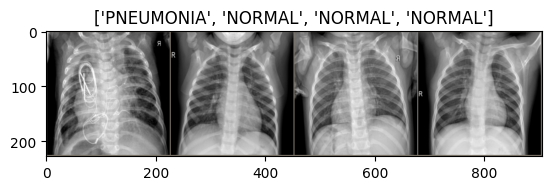

In [7]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes_ = next(iter(dataloaders['train']))
out = utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes_[:4]])

### Setting up the model agnostic code and initializing the ResNet18 model

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


### Defining the hyperparameters for the model

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

### Training the model

In [11]:
num_epochs = 10

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        running_loss = 0.0
        running_corrects = 0

        dataloader = tqdm(dataloaders[phase], desc=f"{phase} Batches", leave=False)
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc.item())
        else:
            val_losses.append(epoch_loss)
            val_accs.append(epoch_acc.item())
        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

Epoch 1/10


train Loss: 0.0627 Acc: 0.9776


val Loss: 0.0779 Acc: 1.0000
Epoch 2/10


train Loss: 0.0311 Acc: 0.9879


val Loss: 0.2044 Acc: 0.8750
Epoch 3/10


train Loss: 0.0172 Acc: 0.9941


val Loss: 0.2755 Acc: 0.8125
Epoch 4/10


train Loss: 0.0239 Acc: 0.9914


val Loss: 0.2930 Acc: 0.8750
Epoch 5/10


train Loss: 0.0107 Acc: 0.9967


val Loss: 0.0430 Acc: 1.0000
Epoch 6/10


train Loss: 0.0110 Acc: 0.9960


val Loss: 0.0250 Acc: 1.0000
Epoch 7/10


train Loss: 0.0210 Acc: 0.9927


val Loss: 0.8170 Acc: 0.6875
Epoch 8/10


train Loss: 0.0096 Acc: 0.9964


val Loss: 0.0679 Acc: 1.0000
Epoch 9/10


train Loss: 0.0054 Acc: 0.9981


val Loss: 0.0578 Acc: 1.0000
Epoch 10/10


train Loss: 0.0057 Acc: 0.9977


val Loss: 0.3185 Acc: 0.9375


Plotting the loss curve and accuracy curve

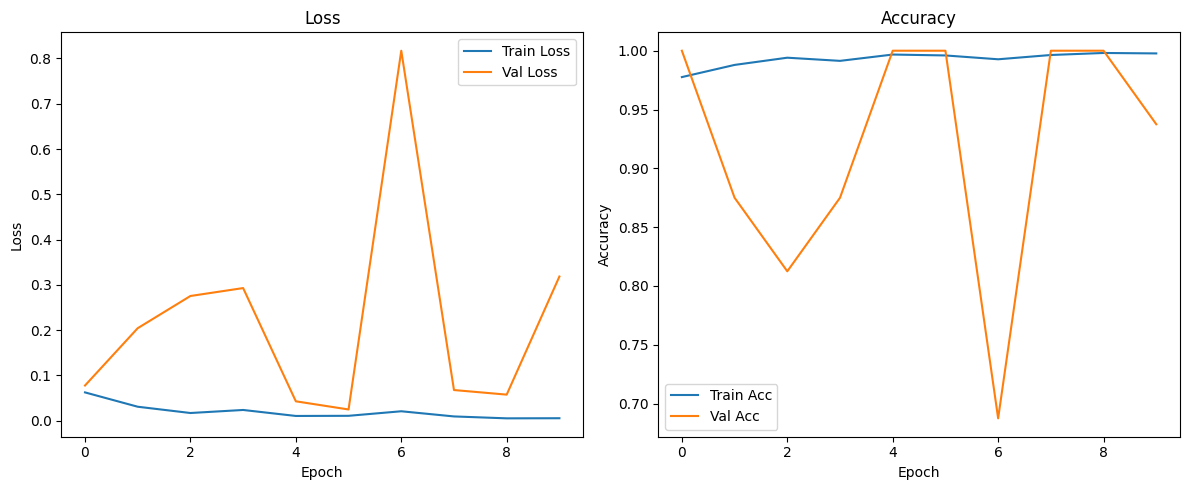

In [12]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

### Evaluating (testing) the trained model

In [13]:
model.eval()
y_true = []
y_pred = []
y_score = []

with torch.no_grad():
    for inputs, labels in tqdm(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)[:, 1]
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_score.extend(probs.cpu().numpy())


100%|██████████| 20/20 [04:16<00:00, 12.84s/it]


Printing confusion matrix and classification report


Classification Report:
              precision    recall  f1-score   support

      NORMAL       1.00      0.48      0.65       234
   PNEUMONIA       0.76      1.00      0.87       390

    accuracy                           0.81       624
   macro avg       0.88      0.74      0.76       624
weighted avg       0.85      0.81      0.79       624


Confusion Matrix:


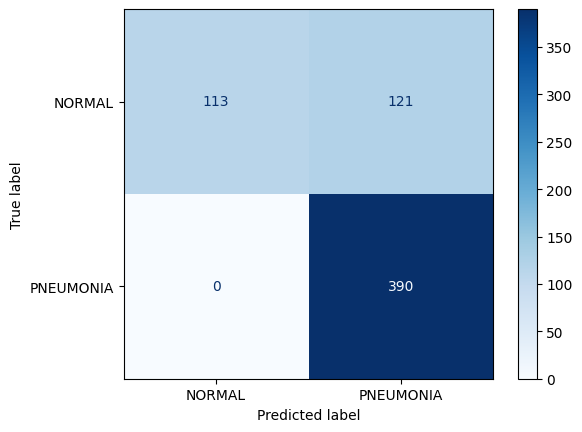

In [14]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Plotting ROC curve

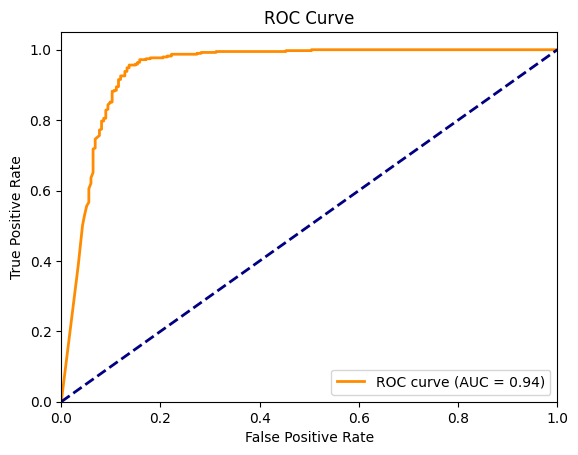

In [15]:
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Plotting the precision-recall curve

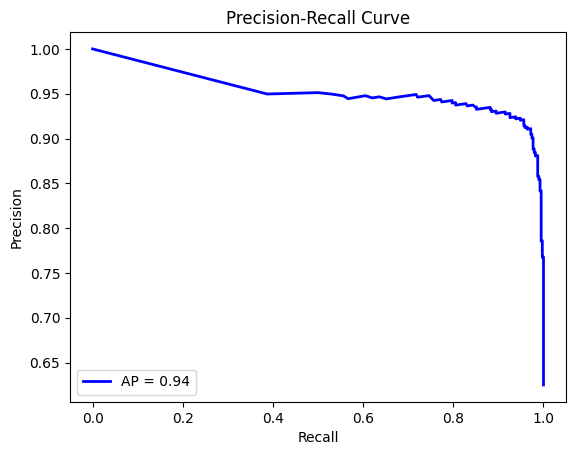

In [16]:
precision, recall, thresholds = precision_recall_curve(y_true, y_score)
ap_score = average_precision_score(y_true, y_score)

plt.figure()
plt.plot(recall, precision, color='b', lw=2, label=f'AP = {ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

### Saving the model

In [17]:
model_save_path = '/content/resnet_chest_xray.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/resnet_chest_xray.pth


Downloading the model to our local storage

In [18]:
from google.colab import files
files.download(model_save_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Thank you